<small><i>This notebook was put together by [Jake Vanderplas](http://www.vanderplas.com) for PyCon 2014. Source and license info is on [GitHub](https://github.com/jakevdp/sklearn_pycon2014/).</i></small>

# Supervised Learning In-Depth: SVMs and Random Forests

There are many machine learning algorithms available; here we'll go into brief detail on two of the most common and interesting ones: **Support Vector Machines (SVMs)** and **Random Forests**.

By the end of this section you should:

- have a qualitative idea of what problem Support Vector Machines are trying to solve
- understand how decision trees work
- understand how multiple decision trees are combined into *Random Forests*

As before, we'll start by getting our notebook ready for interactive plotting:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

## Support Vector Machines

Support Vector Machines (SVMs) are a powerful supervised learning algorithm used for **classification** or for **regression**. SVMs are a **discriminative** classifier: that is, they draw a boundary between clusters of data.

Let's show a quick example of support vector classification. First we need to create a dataset:

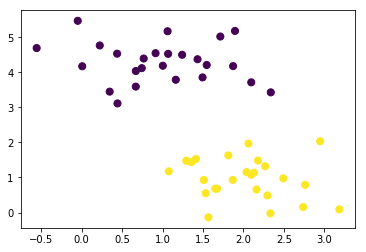

In [2]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=50, centers=2,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50);

Now we'll fit a Support Vector Machine Classifier to these points:

In [3]:
from sklearn.svm import SVC # "Support Vector Classifier"
clf = SVC(kernel='linear')
clf.fit(X, y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

To better visualize what's happening here, let's create a quick convenience function that will plot SVM decision boundaries for us:

In [4]:
def plot_svc_decision_function(clf):
    """Plot the decision function for a 2D SVC"""
    x = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    y = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    Y, X = np.meshgrid(y, x)
    P = np.zeros_like(X)
    for i, xi in enumerate(x):
        for j, yj in enumerate(y):
            P[i, j] = clf.decision_function([xi, yj])
    return plt.contour(X, Y, P, colors='k',
                       levels=[-1, 0, 1],
                       linestyles=['--', '-', '--'])

ValueError: Expected 2D array, got 1D array instead:
array=[-0.75417405 -0.43660962].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

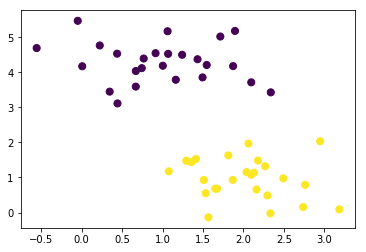

In [5]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)
plot_svc_decision_function(clf)

Notice that the dashed lines touch a couple of the points: these points are known as the "support vectors", and are stored in the ``support_vectors_`` attribute of the classifier:

ValueError: Expected 2D array, got 1D array instead:
array=[-0.75417405 -0.43660962].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

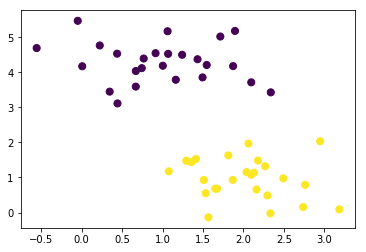

In [6]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, facecolors='none')

The unique thing about SVM is that only the support vectors matter: that is, if you moved any of the other points without letting them cross the decision boundaries, they would have no effect on the classification results!  This can be seen interactively by running the ``fig_code/svm_gui.py`` script:

In [ ]:
# %run fig_code/svm_gui.py

The above version uses a linear kernel; it is also possible to use *radial basis function* kernels as well as others.

In [ ]:
clf = SVC(kernel='rbf')
clf.fit(X, y)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)
plot_svc_decision_function(clf)
plt.scatter(clf.support_vectors_[:, 0], clf.support_vectors_[:, 1],
            s=200, facecolors='none');

The properties of SVMs make them extremely useful classifiers in practice.

We'll leave SVMs for the time being and take a look at another powerful classifier.

## Random Forests

Random forests are an example of an *ensemble learner* built on decision trees. For this reason we'll first discuss decision trees themselves:

### Decision Trees

Here we'll explore a class of algorithms based on Decision trees. Decision trees at their root (Ha!) are extremely intuitive.  They encode a series of binary choices in a process that parallels how a person might classify things themselves, but using an information criterion to decide which question is most fruitful at each step.  For example, if you wanted to create a guide to identifying an animal found in nature, you might ask the following series of questions:

- Is the animal bigger or smaller than a meter long?
    + *bigger*: does the animal have horns?
        - *yes*: are the horns longer than ten centimeters?
        - *no*: is the animal wearing a collar
    + *smaller*: does the animal have two or four legs?
        - *two*: does the animal have wings?
        - *four*: does the animal have a bushy tail?

and so on.  This binary splitting of questions is the essence of a decision tree.

In [ ]:
from sklearn.tree import DecisionTreeClassifier

In [ ]:
X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=0.60)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50)

We'll start by defining a convenience function which allows us to plot the predicted value in the background:

In [ ]:
def plot_estimator(estimator, X, y):
    estimator.fit(X, y)
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 50),
                         np.linspace(y_min, y_max, 50))
    Z = estimator.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)
    plt.figure()
    plt.pcolormesh(xx, yy, Z, alpha=0.3)

    # Plot also the training points
    plt.scatter(X[:, 0], X[:, 1], c=y, s=50)
    plt.axis('tight')
    plt.axis('off')
    plt.tight_layout()

In [ ]:
clf = DecisionTreeClassifier(max_depth=10)
plot_estimator(clf, X, y)

### Random Forests

One problem with decision trees is that they can end up **over-fitting** the data. They are such flexible models that, given a large depth, they can quickly memorize the inputs, which doesn't generalize well to previously unseen data. One way to get around this is to use many slightly different decision trees in concert. This is known as **Random Forests**, and is one of the more common techniques of **ensemble learning** (i.e. combining the results from several estimators.

In [ ]:
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=10, random_state=0)
plot_estimator(clf, X, y)

It's difficult to see in this example, but for more complicated data, random forests can be a very powerful technique.

## Exercise: Classifying Digits

We previously saw the **hand-written digits** data. Let's use that here to test the efficacy of the SVM and Random Forest classifiers.

In [ ]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.keys()

In [ ]:
X = digits.data
y = digits.target
print(X.shape)
print(y.shape)

To remind us what we're looking at, we'll visualize the first few data points:

In [ ]:
# set up the figure
fig = plt.figure(figsize=(6, 6))  # figure size in inches
fig.subplots_adjust(left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

# plot the digits: each image is 8x8 pixels
for i in range(64):
    ax = fig.add_subplot(8, 8, i + 1, xticks=[], yticks=[])
    ax.imshow(digits.images[i], cmap=plt.cm.binary, interpolation='nearest')
    
    # label the image with the target value
    ax.text(0, 7, str(digits.target[i]))

We can quickly classify the digits using a decision tree as follows:

In [ ]:
from sklearn.cross_validation import train_test_split
from sklearn import metrics

Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)
clf = DecisionTreeClassifier(max_depth=5)
clf.fit(Xtrain, ytrain)
ypred = clf.predict(Xtest)

plt.imshow(metrics.confusion_matrix(ypred, ytest),
           interpolation='nearest', cmap=plt.cm.binary)
plt.colorbar()
plt.xlabel("true label")
plt.ylabel("predicted label");

### Exercise
1. Perform this classification task with ``sklearn.svm.SVC``. How does the choice of kernel affect the results?
2. Perform this classification task with ``sklearn.ensemble.RandomForestClassifier``.  How does the ``max_depth``, ``max_features``, and ``n_estimators`` affect the results?
3. Try a few sets of parameters for each model and check the F1 score (``sklearn.metrics.f1_score``) on your results. What's the best F1 score you can reach?

In [ ]:
# run this to load the solution
#  %load solutions/04_svm_rf.py